In [39]:
import os
import torch
import torchaudio
import numpy as np
from tqdm import tqdm

def analyze_audio_quality(data_dir):
    durations = []
    problematic_files = {
        'zero_duration': [],
        'too_short': [],
        'too_long': [],
        'load_error': [],
        'clipping': [],
        'low_volume': []
    }
    
    print("오디오 파일 품질 분석 중...")
    for root, _, files in os.walk(data_dir):
        for file in tqdm(files):
            if file.endswith('.wav') and '_normalized' in file:
                file_path = os.path.join(root, file)
                try:
                    # 오디오 로드
                    waveform, sample_rate = torchaudio.load(file_path)
                    duration = waveform.shape[1] / sample_rate
                    
                    # 길이 검사
                    if duration == 0:
                        problematic_files['zero_duration'].append(file_path)
                    elif duration < 1:
                        problematic_files['too_short'].append(file_path)
                    elif duration > 10:
                        problematic_files['too_long'].append(file_path)
                    
                    durations.append(duration)
                    
                    # 정규화 검사
                    peak = float(torch.max(torch.abs(waveform)))
                    if peak > 1.0:
                        problematic_files['clipping'].append(file_path)
                    elif peak < 0.3:
                        problematic_files['low_volume'].append(file_path)
                        
                except Exception as e:
                    problematic_files['load_error'].append(file_path)
    
    # 이상치 분석
    durations = np.array(durations)
    Q1 = np.percentile(durations, 25)
    Q3 = np.percentile(durations, 75)
    IQR = Q3 - Q1
    outliers = durations[(durations < (Q1 - 1.5 * IQR)) | (durations > (Q3 + 1.5 * IQR))]
    
    print("\n## 오디오 품질 분석 결과")
    print(f"총 파일 수: {len(durations)}")
    print(f"\n길이 통계:")
    print(f"- 평균 길이: {np.mean(durations):.2f}초")
    print(f"- 중간값: {np.median(durations):.2f}초")
    print(f"- 최소 길이: {np.min(durations):.2f}초")
    print(f"- 최대 길이: {np.max(durations):.2f}초")
    
    print(f"\n문제 파일 통계:")
    print(f"- 이상치 개수: {len(outliers)}개")
    print(f"- 0초 길이: {len(problematic_files['zero_duration'])}개")
    print(f"- 너무 짧은 파일: {len(problematic_files['too_short'])}개")
    print(f"- 너무 긴 파일: {len(problematic_files['too_long'])}개")
    print(f"- 클리핑 발생: {len(problematic_files['clipping'])}개")
    print(f"- 볼륨 부족: {len(problematic_files['low_volume'])}개")
    print(f"- 로드 실패: {len(problematic_files['load_error'])}개")
    
    return durations, outliers, problematic_files


In [19]:
data_dir = "/home/summer/AudioLDM-training-finetuning/data/dataset/audioset/zip_audios/unbalanced_train_segments"
durations, outliers, problematic_files = analyze_audio_quality(data_dir)


오디오 파일 품질 분석 중...


0it [00:00, ?it/s]
100%|██████████| 2235/2235 [00:04<00:00, 543.50it/s]


## 오디오 품질 분석 결과
총 파일 수: 50961

길이 통계:
- 평균 길이: 9.86초
- 중간값: 10.00초
- 최소 길이: 0.00초
- 최대 길이: 10.01초

문제 파일 통계:
- 이상치 개수: 12376개
- 0초 길이: 1개
- 너무 짧은 파일: 4개
- 너무 긴 파일: 3204개
- 클리핑 발생: 0개
- 볼륨 부족: 7699개
- 로드 실패: 1개


In [34]:
import os
import torch
import torchaudio
import numpy as np
from tqdm import tqdm

def normalize_and_validate_audio(data_dir):
    stats = {
        'total_files': 0,
        'processed_files': 0,
        'failed_files': [],
        'volume_stats': []
    }
    
    print("오디오 파일 정규화 및 검증 중...")
    for root, _, files in os.walk(data_dir):
        for file in tqdm(files):
            if file.endswith('.wav'):
                file_path = os.path.join(root, file)
                stats['total_files'] += 1
                
                try:
                    # 오디오 로드
                    waveform, sample_rate = torchaudio.load(file_path)
                    
                    # 0초 길이 파일 건너뛰기
                    if waveform.shape[1] == 0:
                        continue
                    
                    # 정규화 수행
                    max_val = torch.abs(waveform).max()
                    if max_val > 0:
                        normalized_waveform = waveform / max_val
                        
                        # 정규화된 파일 저장
                        normalized_path = file_path.replace('.wav', '_normalized.wav')
                        torchaudio.save(normalized_path, normalized_waveform, sample_rate, encoding='PCM_S', bits_per_sample=16)
                        
                        # 볼륨 통계 저장
                        peak = float(torch.max(torch.abs(normalized_waveform)))
                        rms = float(torch.sqrt(torch.mean(normalized_waveform ** 2)))
                        stats['volume_stats'].append({
                            'file': file_path,
                            'peak': peak,
                            'rms': rms
                        })
                        stats['processed_files'] += 1
                        
                except Exception as e:
                    stats['failed_files'].append((file_path, str(e)))
                    continue
    
    print("\n## 정규화 결과")
    print(f"총 파일 수: {stats['total_files']}")
    print(f"처리된 파일 수: {stats['processed_files']}")
    print(f"실패한 파일 수: {len(stats['failed_files'])}")
    
    # 볼륨 통계 계산
    peaks = [s['peak'] for s in stats['volume_stats']]
    rms_values = [s['rms'] for s in stats['volume_stats']]
    
    print("\n## 정규화 후 볼륨 통계")
    print(f"평균 피크값: {np.mean(peaks):.4f}")
    print(f"평균 RMS: {np.mean(rms_values):.4f}")
    
    return stats


In [35]:
data_dir = "/home/summer/AudioLDM-training-finetuning/data/dataset/audioset/zip_audios/unbalanced_train_segments"
stats = normalize_and_validate_audio(data_dir)


오디오 파일 정규화 및 검증 중...


0it [00:00, ?it/s]
100%|██████████| 2235/2235 [00:15<00:00, 143.45it/s]


## 정규화 결과
총 파일 수: 50961
처리된 파일 수: 50960
실패한 파일 수: 0

## 정규화 후 볼륨 통계
평균 피크값: 1.0000
평균 RMS: 0.1426


In [40]:
analyze_audio_quality(data_dir)

오디오 파일 품질 분석 중...


0it [00:00, ?it/s]
100%|██████████| 4470/4470 [00:06<00:00, 686.49it/s]



## 오디오 품질 분석 결과
총 파일 수: 50960

길이 통계:
- 평균 길이: 9.86초
- 중간값: 10.00초
- 최소 길이: 0.63초
- 최대 길이: 10.01초

문제 파일 통계:
- 이상치 개수: 12375개
- 0초 길이: 0개
- 너무 짧은 파일: 4개
- 너무 긴 파일: 3204개
- 클리핑 발생: 0개
- 볼륨 부족: 0개
- 로드 실패: 0개


(array([10.        , 10.        , 10.        , ...,  9.77078125,
        10.        , 10.        ]),
 array([ 9.999625  ,  9.093     ,  9.61284375, ..., 10.0006875 ,
        10.00065625,  9.77078125]),
 {'zero_duration': [],
  'too_short': ['/home/summer/AudioLDM-training-finetuning/data/dataset/audioset/zip_audios/unbalanced_train_segments/unbalanced_train_segments_part34/YmE7U-Eyht6U_normalized.wav',
   '/home/summer/AudioLDM-training-finetuning/data/dataset/audioset/zip_audios/unbalanced_train_segments/unbalanced_train_segments_part16/YIYXZ_0krE8k_normalized.wav',
   '/home/summer/AudioLDM-training-finetuning/data/dataset/audioset/zip_audios/unbalanced_train_segments/unbalanced_train_segments_part40/YzhopcEHglEI_normalized.wav',
   '/home/summer/AudioLDM-training-finetuning/data/dataset/audioset/zip_audios/unbalanced_train_segments/unbalanced_train_segments_part14/YEvQtf5dvClc_normalized.wav'],
  'too_long': ['/home/summer/AudioLDM-training-finetuning/data/dataset/audioset/zip_audio

In [33]:
import os
from tqdm import tqdm

def remove_duplicate_normalized_files(data_dir):
    removed_count = 0
    
    print("중복 정규화 파일 삭제 중...")
    for root, _, files in os.walk(data_dir):
        for file in tqdm(files):
            if file.endswith('_normalized_normalized.wav') or file.endswith('_normalized.wav'):
                file_path = os.path.join(root, file)
                try:
                    os.remove(file_path)
                    removed_count += 1
                except Exception as e:
                    print(f"파일 삭제 실패: {file_path}, 에러: {str(e)}")
    
    print(f"\n총 {removed_count}개의 파일이 삭제되었습니다.")

# 실행
remove_duplicate_normalized_files(data_dir)


중복 정규화 파일 삭제 중...


0it [00:00, ?it/s]
100%|██████████| 6705/6705 [00:00<00:00, 20080.35it/s]


총 138996개의 파일이 삭제되었습니다.


In [41]:
import os
import shutil
from tqdm import tqdm

def move_original_files(source_dir, target_dir):
    if not os.path.exists(target_dir):
        os.makedirs(target_dir)
        
    moved_count = 0
    print("원본 파일 이동 중...")
    
    for root, dirs, files in os.walk(source_dir):
        for file in tqdm(files):
            if file.endswith('.wav') and '_normalized' not in file:
                # 원본 파일만 이동
                source_path = os.path.join(root, file)
                relative_path = os.path.relpath(root, source_dir)
                target_path = os.path.join(target_dir, relative_path)
                
                # 대상 디렉토리가 없으면 생성
                if not os.path.exists(target_path):
                    os.makedirs(target_path)
                
                # 파일 이동
                shutil.move(source_path, os.path.join(target_path, file))
                moved_count += 1
    
    print(f"\n총 {moved_count}개의 원본 파일이 이동되었습니다.")

# 실행
source_dir = "/home/summer/AudioLDM-training-finetuning/data/dataset/audioset/zip_audios/unbalanced_train_segments"
target_dir = "/home/summer/AudioLDM-training-finetuning/original_dataset"

move_original_files(source_dir, target_dir)


원본 파일 이동 중...


0it [00:00, ?it/s]
100%|██████████| 4470/4470 [00:00<00:00, 43117.63it/s]


총 50961개의 원본 파일이 이동되었습니다.


In [42]:
import os
from tqdm import tqdm

def rename_normalized_files(source_dir):
    renamed_count = 0
    
    print("파일 이름에서 '_normalized' 제거 중...")
    for root, _, files in os.walk(source_dir):
        for file in tqdm(files):
            if '_normalized' in file and file.endswith('.wav'):
                old_path = os.path.join(root, file)
                new_path = os.path.join(root, file.replace('_normalized', ''))
                
                try:
                    os.rename(old_path, new_path)
                    renamed_count += 1
                except Exception as e:
                    print(f"파일 이름 변경 실패: {old_path}, 에러: {str(e)}")
    
    print(f"\n총 {renamed_count}개의 파일 이름이 변경되었습니다.")

# 실행
source_dir = "/home/summer/AudioLDM-training-finetuning/data/dataset/audioset/zip_audios/unbalanced_train_segments"
rename_normalized_files(source_dir)


파일 이름에서 '_normalized' 제거 중...


0it [00:00, ?it/s]
100%|██████████| 2235/2235 [00:00<00:00, 60496.72it/s]


총 50960개의 파일 이름이 변경되었습니다.


오디오 파일 분석 중...


0it [00:00, ?it/s]
100%|██████████| 2235/2235 [00:06<00:00, 339.29it/s]
/tmp/ipykernel_2423618/4279785132.py:55: UserWarning: Glyph 44600 (\N{HANGUL SYLLABLE GIL}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_2423618/4279785132.py:55: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_2423618/4279785132.py:55: UserWarning: Glyph 52488 (\N{HANGUL SYLLABLE CO}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_2423618/4279785132.py:55: UserWarning: Glyph 54028 (\N{HANGUL SYLLABLE PA}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_2423618/4279785132.py:55: UserWarning: Glyph 51068 (\N{HANGUL SYLLABLE IL}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_2423618/4279785132.py:55: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_2423618/4279785132.py:55: UserWarning: Glyph 50724 (\N{HANGUL SYLLABLE O}) miss

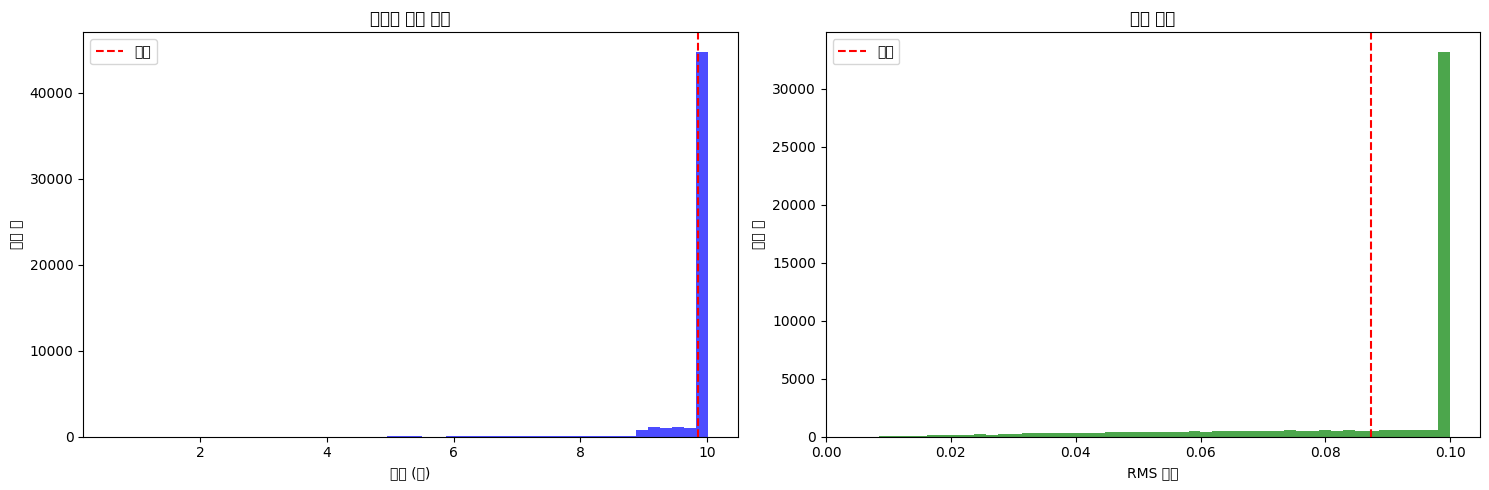


## 오디오 길이 분포 (초)
구간 | 파일 수
-----|--------
0~1 | 4
1~2 | 25
2~3 | 33
3~4 | 74
4~5 | 102
5~6 | 162
6~7 | 224
7~8 | 192
8~9 | 313
9~10 | 8042
10~11 | 41789

## RMS 음량 분포
구간 | 파일 수
-----|--------
0.0~0.1 | 5138
0.1~0.2 | 45822


In [52]:
import os
import torch
import torchaudio
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import defaultdict

def analyze_audio_statistics(data_dir):
    durations = []
    volumes = []
    duration_counts = defaultdict(int)
    volume_counts = defaultdict(int)
    
    print("오디오 파일 분석 중...")
    for root, _, files in os.walk(data_dir):
        for file in tqdm(files):
            if file.endswith('.wav'):
                file_path = os.path.join(root, file)
                try:
                    waveform, sample_rate = torchaudio.load(file_path)
                    
                    # 길이 계산
                    duration = waveform.shape[1] / sample_rate
                    durations.append(duration)
                    duration_counts[int(duration)] += 1
                    
                    # 음량(RMS) 계산
                    volume = torch.sqrt(torch.mean(waveform ** 2)).item()
                    volumes.append(volume)
                    volume_counts[round(volume * 10) / 10] += 1
                    
                except Exception as e:
                    print(f"Error processing {file}: {str(e)}")
    
    # 통계 시각화
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # 길이 분포
    ax1.hist(durations, bins=50, color='blue', alpha=0.7)
    ax1.set_title('오디오 길이 분포')
    ax1.set_xlabel('길이 (초)')
    ax1.set_ylabel('파일 수')
    ax1.axvline(x=np.mean(durations), color='r', linestyle='--', label='평균')
    ax1.legend()
    
    # 음량 분포
    ax2.hist(volumes, bins=50, color='green', alpha=0.7)
    ax2.set_title('음량 분포')
    ax2.set_xlabel('RMS 음량')
    ax2.set_ylabel('파일 수')
    ax2.axvline(x=np.mean(volumes), color='r', linestyle='--', label='평균')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()
    
    # 길이 분포 표 출력
    print("\n## 오디오 길이 분포 (초)")
    print("구간 | 파일 수")
    print("-----|--------")
    for i in range(max(duration_counts.keys()) + 1):
        if duration_counts[i] > 0:
            print(f"{i}~{i+1} | {duration_counts[i]}")
    
    # 음량 분포 표 출력
    print("\n## RMS 음량 분포")
    print("구간 | 파일 수")
    print("-----|--------")
    sorted_volumes = sorted(volume_counts.keys())
    for v in sorted_volumes:
        if volume_counts[v] > 0:
            print(f"{v:.1f}~{v+0.1:.1f} | {volume_counts[v]}")
    
    return durations, volumes, duration_counts, volume_counts

# 실행
data_dir = "/home/summer/AudioLDM-training-finetuning/data/dataset/audioset/zip_audios/normalized"
durations, volumes, duration_counts, volume_counts = analyze_audio_statistics(data_dir)



In [76]:
import os
import torch
import torchaudio
import torchaudio.functional as F
from tqdm import tqdm

def denoise_audio(waveform, sample_rate):
    """향상된 노이즈 제거 기법"""
    # STFT 변환
    spec = torch.stft(
        waveform,
        n_fft=2048,
        hop_length=512,
        win_length=2048,
        window=torch.hann_window(2048).to(waveform.device),
        return_complex=True
    )
    
    # 스펙트로그램 계산
    spec_mag = torch.abs(spec)
    spec_phase = torch.angle(spec)
    
    # Wiener 필터링
    noise_estimate = torch.median(spec_mag[:, :, :int(0.1 * spec_mag.shape[2])], dim=2)[0].unsqueeze(-1)
    wiener_filter = (spec_mag ** 2) / (spec_mag ** 2 + noise_estimate ** 2)
    
    # 스펙트럴 서브트랙션
    alpha = 2.0  # 오버서브트랙션 팩터
    beta = 0.1   # 노이즈 플로어
    spec_mag_clean = torch.maximum(
        spec_mag - alpha * noise_estimate,
        beta * spec_mag
    )
    
    # 주파수 마스킹
    mask = wiener_filter * (spec_mag_clean / (spec_mag + 1e-8))
    spec_mag_enhanced = spec_mag * mask
    
    # 시간-주파수 일관성 보존
    temporal_smoothing = torch.nn.functional.avg_pool1d(
        spec_mag_enhanced.transpose(1, 2),
        kernel_size=3,
        stride=1,
        padding=1
    ).transpose(1, 2)
    
    # 신호 재구성
    spec_complex = temporal_smoothing * torch.exp(1j * spec_phase)
    filtered_waveform = torch.istft(
        spec_complex,
        n_fft=2048,
        hop_length=512,
        win_length=2048,
        window=torch.hann_window(2048).to(waveform.device)
    )
    
    return filtered_waveform




def normalize_audio_files(data_dir, output_dir, target_rms=-6):
    os.makedirs(output_dir, exist_ok=True)
    
    normalized_files = 0
    failed_files = []
    
    print("오디오 파일 정규화 및 노이즈 제거 중...")
    for root, _, files in os.walk(data_dir):
        for file in tqdm(files):
            if file.endswith('.wav'):
                input_path = os.path.join(root, file)
                rel_path = os.path.relpath(root, data_dir)
                output_subdir = os.path.join(output_dir, rel_path)
                os.makedirs(output_subdir, exist_ok=True)
                output_path = os.path.join(output_subdir, file)
                
                try:
                    # 오디오 로드
                    waveform, sample_rate = torchaudio.load(input_path)
                    
                    # 노이즈 제거
                    waveform = denoise_audio(waveform, sample_rate)
                    
                    # RMS 계산
                    rms = torch.sqrt(torch.mean(waveform ** 2))
                    if rms > 0:  # 0으로 나누기 방지
                        current_db = 20 * torch.log10(rms)
                        
                        # 목표 RMS로 정규화 (더 높은 음량으로)
                        db_change = target_rms - current_db
                        scaling_factor = 10 ** (db_change / 20)
                        normalized_waveform = waveform * scaling_factor
                        
                        # 추가 증폭 (더 높은 RMS를 위해)
                        boost_factor = 1.5  # 음량 부스트
                        normalized_waveform = normalized_waveform * boost_factor
                        
                        # 클리핑 방지 및 최적 스케일링
                        max_val = torch.max(torch.abs(normalized_waveform))
                        if max_val > 1.0:
                            normalized_waveform = normalized_waveform / max_val
                        normalized_waveform = normalized_waveform * 0.98  # 헤드룸 유지
                        
                        # 저장
                        torchaudio.save(
                            output_path, 
                            normalized_waveform, 
                            sample_rate,
                            encoding='PCM_S',
                            bits_per_sample=16
                        )
                        normalized_files += 1
                    
                except Exception as e:
                    failed_files.append((input_path, str(e)))
    
    print("\n## 정규화 결과")
    print(f"처리된 파일 수: {normalized_files}")
    print(f"실패한 파일 수: {len(failed_files)}")
    
    if failed_files:
        print("\n## 실패한 파일 목록:")
        for file_path, error in failed_files:
            print(f"파일: {file_path}")
            print(f"에러: {error}\n")
    
    return normalized_files, failed_files

# 실행
data_dir = "/home/summer/AudioLDM-training-finetuning/original_dataset"
output_dir = "/home/summer/AudioLDM-training-finetuning/data/dataset/audioset/zip_audios/unbalanced_train_segments_normalized"
normalized_files, failed_files = normalize_audio_files(data_dir, output_dir)


오디오 파일 정규화 및 노이즈 제거 중...


0it [00:00, ?it/s]
100%|██████████| 2235/2235 [01:00<00:00, 36.87it/s]


## 정규화 결과
처리된 파일 수: 50248
실패한 파일 수: 1

## 실패한 파일 목록:
파일: /home/summer/AudioLDM-training-finetuning/original_dataset/unbalanced_train_segments_part25/YWudGD6ZHRoY.wav
에러: 2D or 3D (batch mode) tensor expected for input, but got: [ torch.FloatTensor{1,1,0} ]



In [77]:
import os
import torch
import torchaudio
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import defaultdict

def analyze_normalized_audio(normalized_dir):
    volumes = defaultdict(int)
    total_files = 0
    
    print("정규화된 오디오 파일 분석 중...")
    for root, _, files in os.walk(normalized_dir):
        for file in tqdm(files):
            if file.endswith('.wav'):
                file_path = os.path.join(root, file)
                try:
                    waveform, _ = torchaudio.load(file_path)
                    
                    # RMS 음량 계산
                    volume = torch.sqrt(torch.mean(waveform ** 2)).item()
                    volumes[round(volume * 10) / 10] += 1
                    total_files += 1
                    
                except Exception as e:
                    print(f"Error processing {file}: {str(e)}")
    
    # 음량 분포 출력
    print("\n## 정규화된 오디오 RMS 음량 분포")
    print("구간 | 파일 수 | 비율(%)")
    print("-----|---------|----------")
    
    sorted_volumes = sorted(volumes.keys())
    for v in sorted_volumes:
        percentage = (volumes[v] / total_files) * 100
        print(f"{v:.1f}~{v+0.1:.1f} | {volumes[v]:8d} | {percentage:6.2f}%")
    
    print(f"\n총 파일 수: {total_files}")
    print(f"평균 RMS: {sum([k * v for k, v in volumes.items()]) / total_files:.4f}")

# 실행
normalized_dir = "/home/summer/AudioLDM-training-finetuning/data/dataset/audioset/zip_audios/unbalanced_train_segments_normalized"
analyze_normalized_audio(normalized_dir)


정규화된 오디오 파일 분석 중...


0it [00:00, ?it/s]
100%|██████████| 2193/2193 [00:06<00:00, 335.44it/s]


## 정규화된 오디오 RMS 음량 분포
구간 | 파일 수 | 비율(%)
-----|---------|----------
0.0~0.1 |     9181 |  18.27%
0.1~0.2 |    32591 |  64.86%
0.2~0.3 |     7611 |  15.15%
0.3~0.4 |      749 |   1.49%
0.4~0.5 |      105 |   0.21%
0.5~0.6 |        9 |   0.02%
0.6~0.7 |        2 |   0.00%

총 파일 수: 50248
평균 RMS: 0.1006
